In [1]:
import pandas as pd 
import os
import matplotlib.pyplot as plt
import json
import mne
import numpy as np
from tqdm import tqdm
import re
from sklearn.preprocessing import StandardScaler
from multiprocessing import Pool
import warnings
import math

os.chdir('../..')

# Load the PSDs
Normalization is not needed for this method!

In [2]:
loaded = np.load('./Generated/Spectrums/psds_array_fft.npz')

results_arr = []

i = 0
while f'psd_{i}' in loaded:
    psd = loaded[f'psd_{i}']
    s_id = int(loaded[f'subject_id_{i}'])
    t_id = int(loaded[f'trial_id_{i}'])
    gender = str(loaded[f'gender_{i}'])
    handiness = str(loaded[f'handiness_{i}'])
    age = int(loaded[f'age_{i}'])
    
    results_arr.append([psd, s_id, t_id, gender, handiness, age])
    i += 1

psd, s_id, t_id, gender, handiness, age = results_arr[10]
psd.shape

(63, 381)

In [3]:
# Parse into two lists will be used furthere
psds_array = [item[0] for item in results_arr]
psds_array = np.array(psds_array)                            # Convert list of PSDs to a numpy array
psds_array = psds_array.reshape((psds_array.shape[0], -1))   # Vectorize 

metadata = [item[1:] for item in results_arr]

psds_array.shape

(31, 24003)

# NFT

In [59]:
from tensorly.decomposition import non_negative_parafac
import tensorly as tl

# Восстановим тензорную форму (31, 63, 381)
tensor = psds_array.reshape(psds_array.shape[0], 63, 381)
tl.set_backend('numpy')

# Понижаем размерность через NTF
# ДЛЯ МОРЛЕТА ИСПОЛЬЗУЙ ...
# Для FFT ИСПОЛЬЗУЙ 13
rank = 14
weights, factors = non_negative_parafac(tensor, rank=rank, return_errors=False)

# factors = (A, B, C)
A = factors[0]  # By subjects (31, rank)
B = factors[1]  # By channels (63, rank)
C = factors[2]  # By freqs (40*2, rank)

reduced_data = A # because it contains by subjects

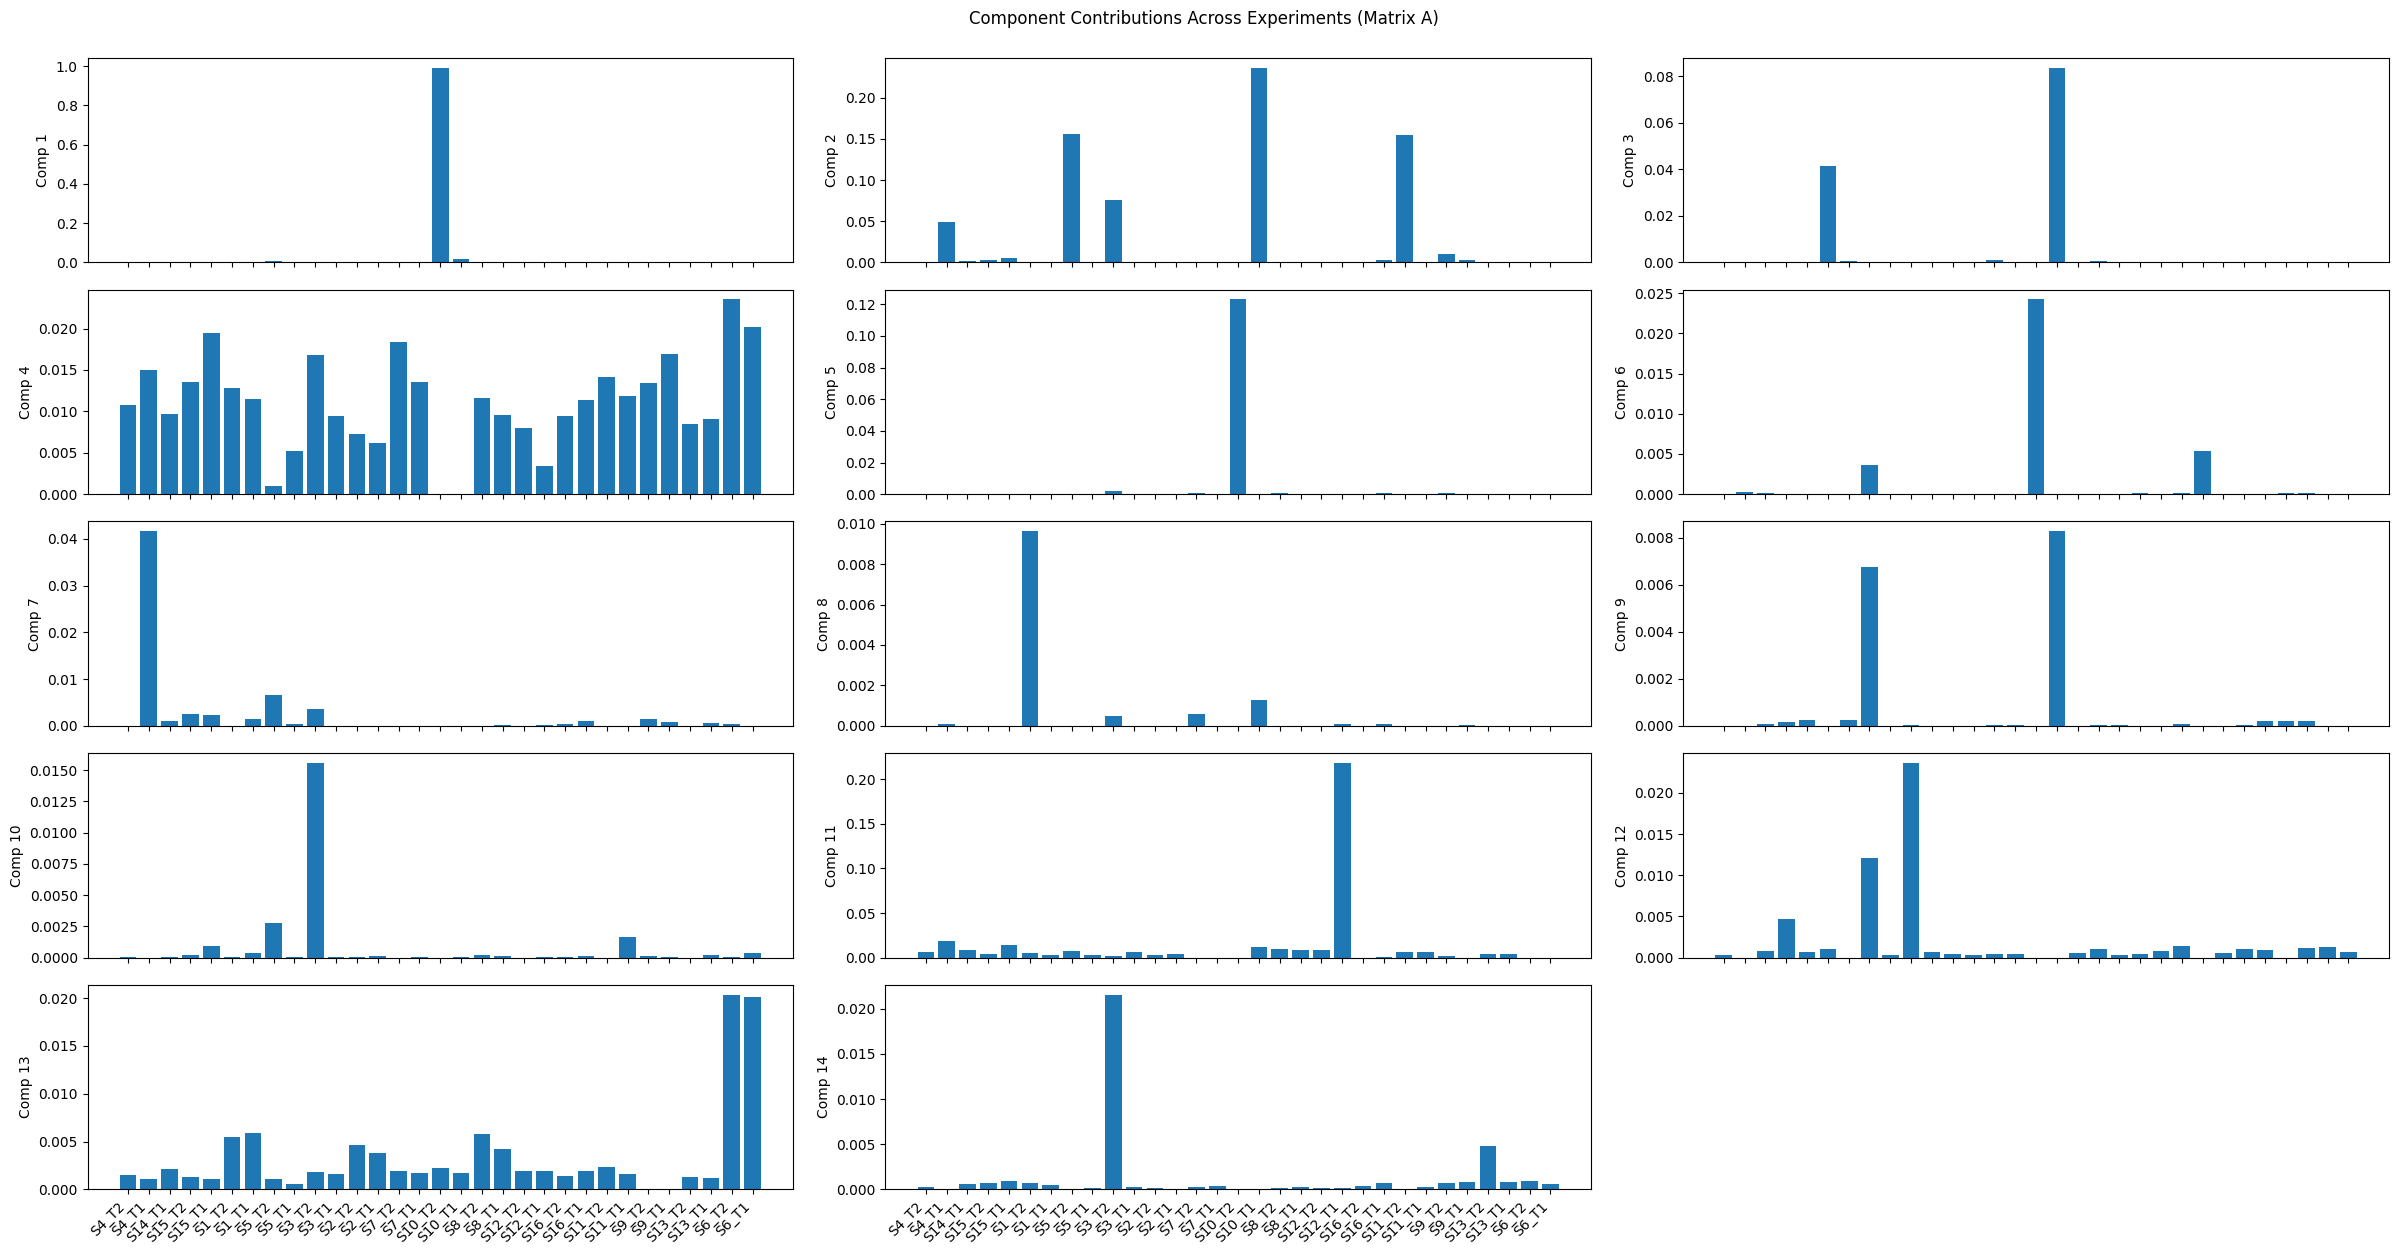

In [60]:
n_components = A.shape[1]
n_cols = 3
n_rows = math.ceil(n_components / n_cols)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(8 * n_cols, 2.5 * n_rows), sharex=True)
axes = axes.flatten()  # упрощаем индексацию

for r in range(n_components):
    axes[r].bar(range(1, A.shape[0] + 1), A[:, r])
    axes[r].set_ylabel(f'Comp {r+1}')
    axes[r].set_xticks(range(1, A.shape[0] + 1))
    axes[r].set_xticklabels([f'S{meta[0]}_T{meta[1]}' for meta in metadata], rotation=45, ha='right')

# Убираем пустые графики если компонентов меньше чем subplot-ов
for ax in axes[n_components:]:
    ax.axis('off')

axes[-1].set_xlabel('Experiments')
plt.suptitle('Component Contributions Across Experiments (Matrix A)', y=1)
plt.tight_layout()

# Сохраняем в файл
plt.savefig('./Generated/Figures/Spectral_Analysis/NTF/FFT_By_Subjects.png', dpi=300, bbox_inches='tight')
plt.show()

Get a simple eeg sample to get channels

In [61]:
# Путь к нужному сэмплу
path = "./Generated/Data/S_1/Trial_1/EEG_clean.fif"  # замените на свой путь

# Загрузка EEG без предупреждений
with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=RuntimeWarning)
    raw = mne.io.read_raw_fif(path, preload=True, verbose=False)

# Оставляем только EEG-каналы
raw.pick_types(eeg=True)

# Результаты
eeg = raw

NOTE: pick_types() is a legacy function. New code should use inst.pick(...).


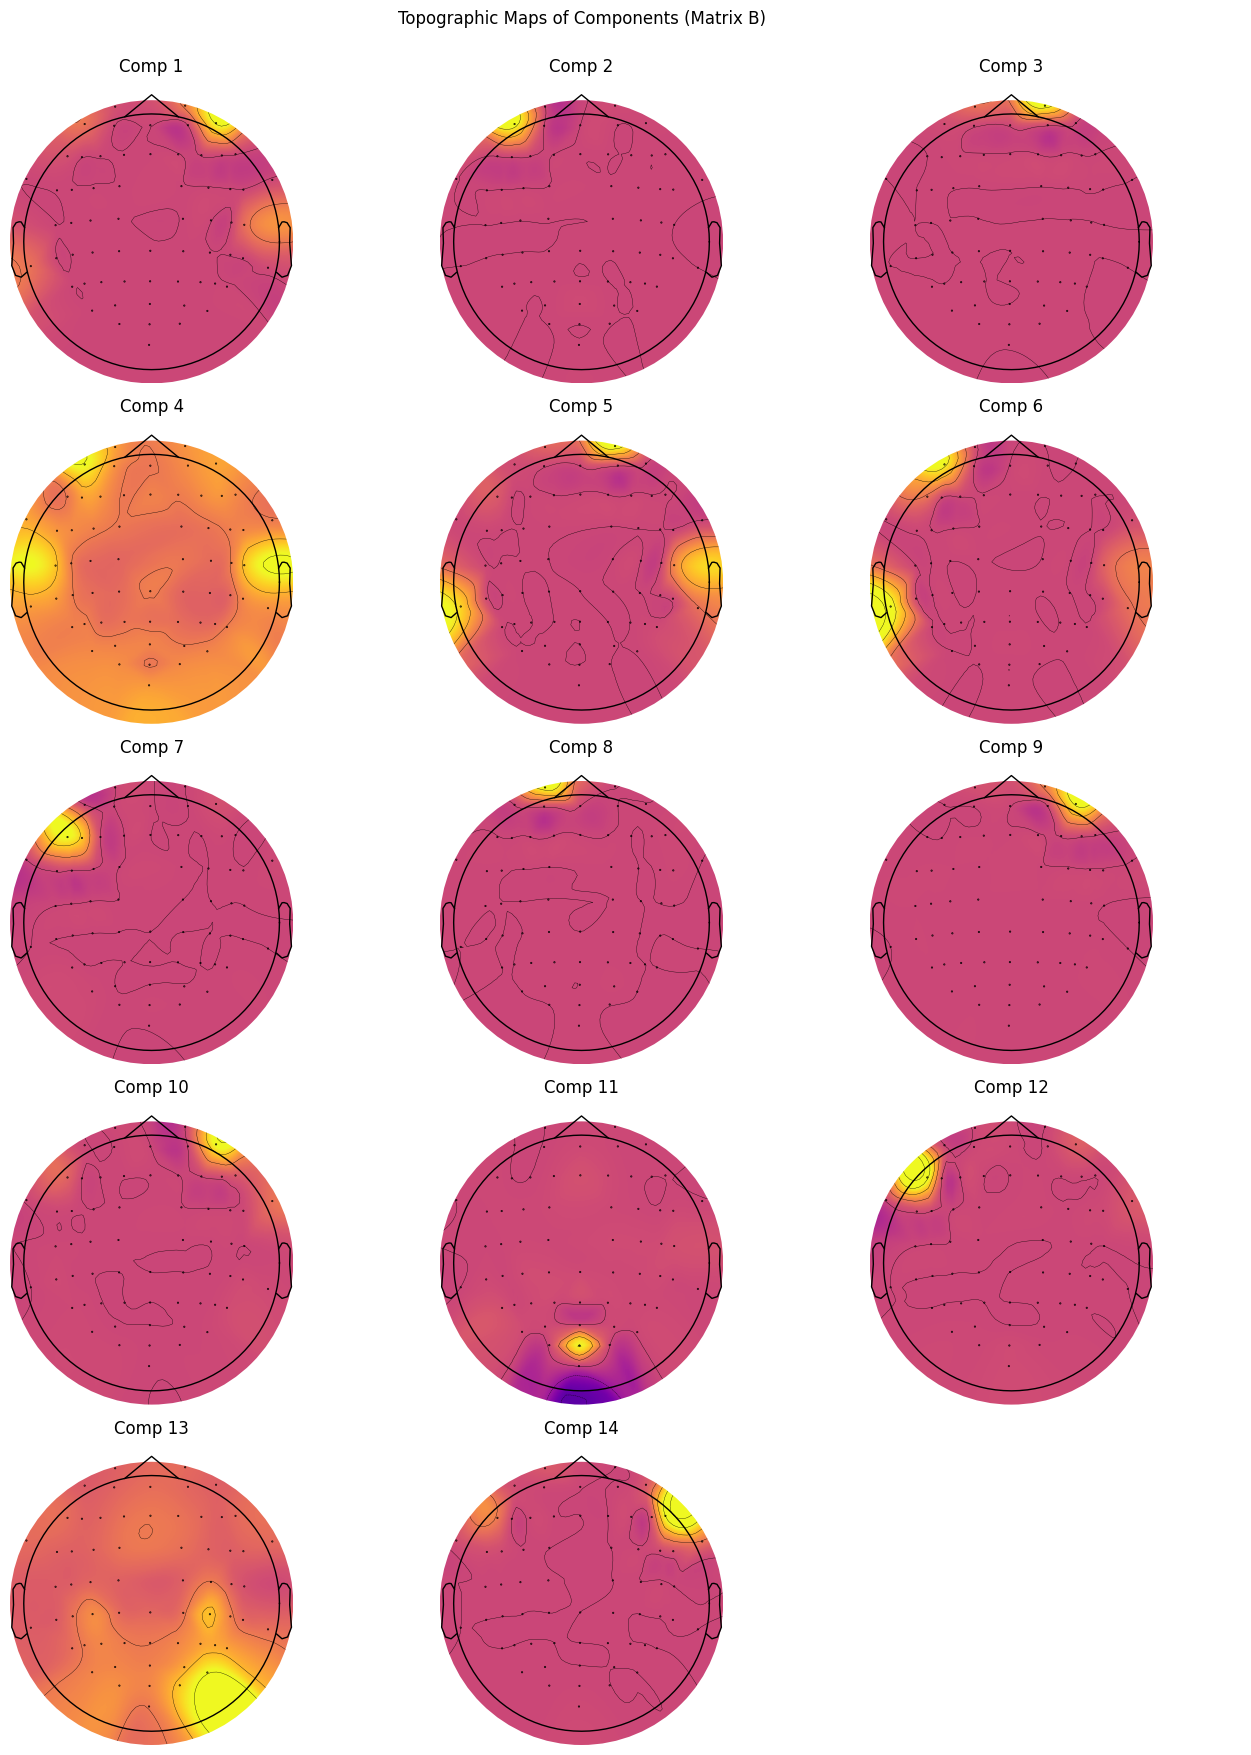

In [62]:
# Названия каналов
ch_names = eeg.info['ch_names']

# Монтируем стандарт 10-20
montage = mne.channels.make_standard_montage('standard_1020')

# Создаем Info
info = mne.create_info(ch_names=ch_names, sfreq=1000, ch_types='eeg')
info.set_montage(montage)

# Визуализация всех компонентов
n_components = B.shape[1]
n_cols = 3
n_rows = math.ceil(n_components / n_cols)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(4.5 * n_cols, 3.5 * n_rows))
axes = np.atleast_1d(axes).flatten()

for k in range(n_components):
    topo_data = B[:, k]
    evoked = mne.EvokedArray(topo_data[:, np.newaxis], info, tmin=0)

    evoked.plot_topomap(
        times=0,
        scalings=1,
        time_format='',
        cmap='plasma',
        axes=axes[k],
        show=False,
        colorbar=False
    )
    axes[k].set_title(f'Comp {k+1}')

# Отключаем лишние подграфики
for ax in axes[n_components:]:
    ax.axis('off')

plt.suptitle("Topographic Maps of Components (Matrix B)", y=1)
plt.tight_layout()

# Сохраняем в файл
plt.savefig('./Generated/Figures/Spectral_Analysis/NTF/FFT_By_Electrodes.png', dpi=300, bbox_inches='tight')
plt.show()

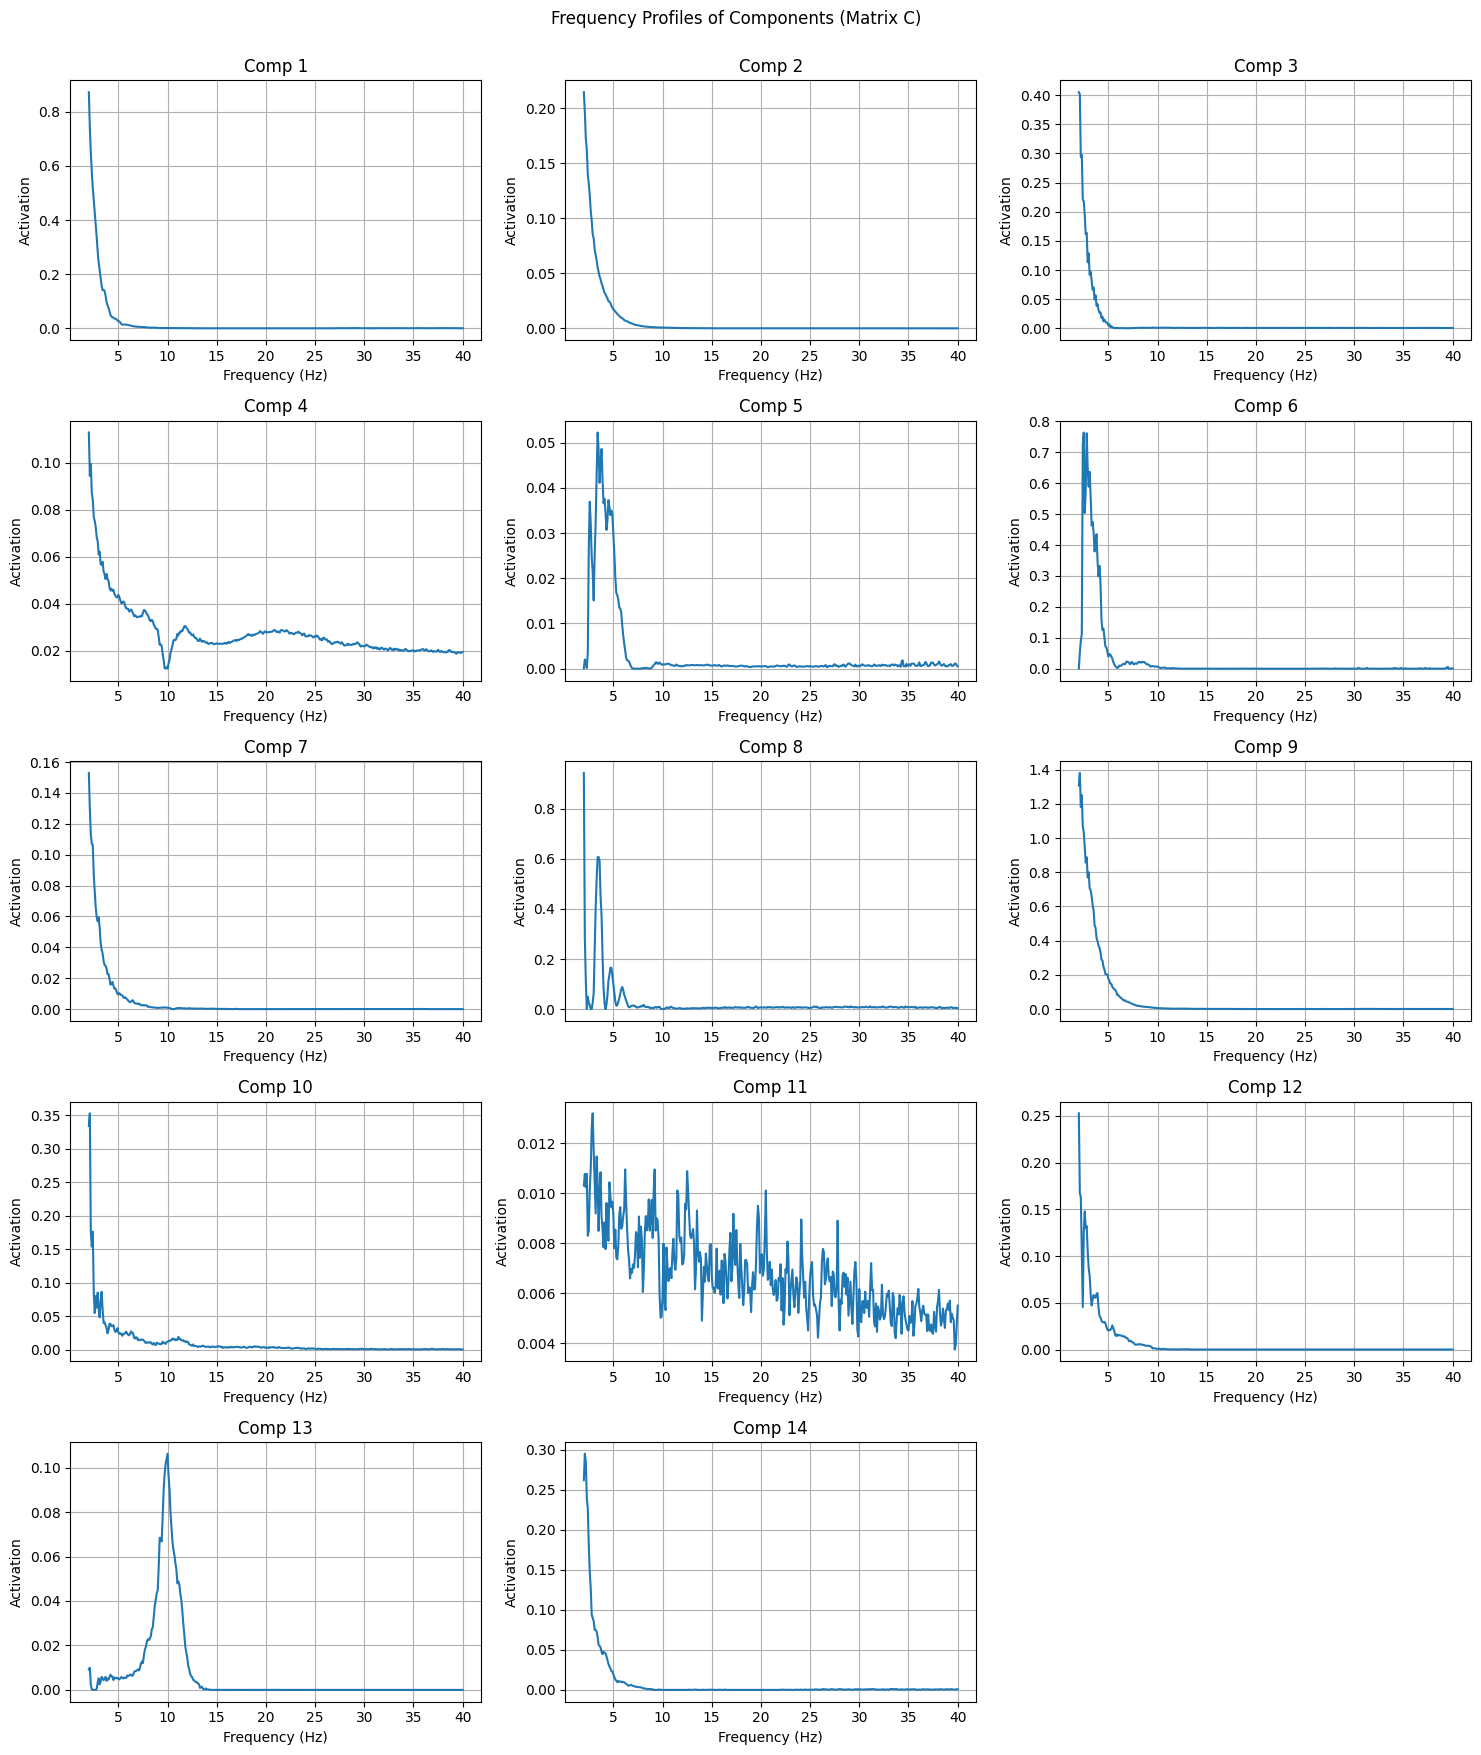

In [63]:
# Параметры
n_components = C.shape[1]
n_cols = 3
n_rows = math.ceil(n_components / n_cols)

freqs = np.linspace(2, 40, C.shape[0])  # Частоты по оси X

# Создаем фигуру
fig, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 3.5 * n_rows))
axes = np.atleast_1d(axes).flatten()

for k in range(n_components):
    ax = axes[k]
    ax.plot(freqs, C[:, k])
    ax.set_title(f'Comp {k+1}')
    ax.set_xlabel('Frequency (Hz)')
    ax.set_ylabel('Activation')
    ax.grid(True)

# Удаляем лишние оси
for ax in axes[n_components:]:
    ax.axis('off')

plt.suptitle('Frequency Profiles of Components (Matrix C)', y=1)
plt.tight_layout()

# Сохраняем в файл
plt.savefig('./Generated/Figures/Spectral_Analysis/NTF/FFT_By_Freqs.png', dpi=300, bbox_inches='tight')
plt.show()